In [2]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_data = pd.read_csv('../doc2vec.csv', sep=',', header=None, nrows=None)

In [4]:
def preprocessing(text, remove_stopwords = False):
    
    r_text = re.sub("[^a-zA-Z]", " ", text)
    
    words = r_text.lower().split()
    
    if remove_stopwords:
        
        stops = set(stopwords.words("english"))
        
        words = [w for w in words if not w in stops]
        
        clean_text = ' '.join(words)
    
    else:
        clean_text = ' '.join(words)
        
    return clean_text

In [5]:
clean_train_text = []
for text in train_data[3]:
    clean_train_text.append(preprocessing(text, remove_stopwords=True))

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_text)
text_sequences = tokenizer.texts_to_sequences(clean_train_text)

In [7]:
train_data = pd.read_csv('data_in/train_clean.csv')

In [8]:
texts = list(train_data['text'])
scores = list(train_data['score'])

sentences = []
for text in texts:
    sentences.append(text.split())

In [9]:
num_features = 100
min_word_count = 0
num_workers = 4
context = 3
downsampling = 1e-3

In [10]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [11]:
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count=min_word_count, window=context, sample=downsampling)

2020-12-13 00:17:15,270 : INFO : collecting all words and their counts
2020-12-13 00:17:15,271 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-13 00:17:15,300 : INFO : PROGRESS: at sentence #10000, processed 182667 words, keeping 22272 word types
2020-12-13 00:17:15,335 : INFO : PROGRESS: at sentence #20000, processed 390126 words, keeping 33563 word types
2020-12-13 00:17:15,376 : INFO : PROGRESS: at sentence #30000, processed 630133 words, keeping 42709 word types
2020-12-13 00:17:15,419 : INFO : PROGRESS: at sentence #40000, processed 885516 words, keeping 51568 word types
2020-12-13 00:17:15,460 : INFO : PROGRESS: at sentence #50000, processed 1132112 words, keeping 58971 word types


Training model...


2020-12-13 00:17:15,503 : INFO : PROGRESS: at sentence #60000, processed 1367071 words, keeping 65607 word types
2020-12-13 00:17:15,508 : INFO : collected 66447 word types from a corpus of 1397102 raw words and 61309 sentences
2020-12-13 00:17:15,508 : INFO : Loading a fresh vocabulary
2020-12-13 00:17:15,582 : INFO : effective_min_count=0 retains 66447 unique words (100% of original 66447, drops 0)
2020-12-13 00:17:15,582 : INFO : effective_min_count=0 leaves 1397102 word corpus (100% of original 1397102, drops 0)
2020-12-13 00:17:15,743 : INFO : deleting the raw counts dictionary of 66447 items
2020-12-13 00:17:15,745 : INFO : sample=0.001 downsamples 15 most-common words
2020-12-13 00:17:15,745 : INFO : downsampling leaves estimated 1375879 word corpus (98.5% of prior 1397102)
2020-12-13 00:17:15,895 : INFO : estimated required memory for 66447 words and 100 dimensions: 86381100 bytes
2020-12-13 00:17:15,896 : INFO : resetting layer weights
2020-12-13 00:17:25,431 : INFO : training

In [33]:
model_name = "100features_0minwords_3context"
model.save(model_name)

In [12]:
def get_features(words, model, num_features):
    
    feature_vector = np.zeros((num_features), dtype=np.float64)
    
    num_words = 0
    
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        
        if w in index2word_set:
            
            num_words += 1
            
            feature_vector = np.add(feature_vector, model[w])
            
    feature_vector = np.divide(feature_vector, num_words)
    
    return feature_vector

In [13]:
def get_dataset(texts, model, num_features):
    
    dataset = list()
    
    for s in texts:
    
        dataset.append(get_features(s, model, num_features))
        
    textFeatureVecs = np.stack(dataset)
    
    return textFeatureVecs

In [14]:
train_data_vecs = get_dataset(sentences, word2vec_model, num_features)

C:\Users\jjae0\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [15]:
train_X = train_data_vecs
train_y = np.array(scores).reshape(-1,1)

# test data

In [16]:
test_data = pd.read_csv('new_test_30.csv')

In [17]:
texts = list(test_data['text'])

sentences = []
for text in texts:
    sentences.append(text.split())

In [18]:
scores = test_data['score']

In [19]:
test_data_vecs = get_dataset(sentences, word2vec_model, num_features)

C:\Users\jjae0\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [20]:
test_X = test_data_vecs
test_y = scores

# model

In [21]:
from numpy import asarray
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [22]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(10, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [105]:
n_inputs, n_outputs = train_X.shape[1], train_y.shape[1]
model = get_model(n_inputs, n_outputs)

In [106]:
model.fit(train_X, train_y, verbose=0, epochs=100)

In [107]:
mae = model.evaluate(test_X, test_y, verbose=0)
print('> %.3f' % mae)

> 0.754


In [108]:
yhat = []
for i in range(30):
    newX = asarray([test_X[i]])
    t = model.predict(newX).round(1)
    yhat.append(t)
    print('{0}번째 / 예측값 : {1}, 실제값 : {2}'.format(i+1, t, test_y[i]))

1번째 / 예측값 : [[6.]], 실제값 : 7.7
2번째 / 예측값 : [[6.]], 실제값 : 6.3
3번째 / 예측값 : [[7.2]], 실제값 : 5.8
4번째 / 예측값 : [[6.8]], 실제값 : 5.4
5번째 / 예측값 : [[6.7]], 실제값 : 6.4
6번째 / 예측값 : [[6.2]], 실제값 : 5.5
7번째 / 예측값 : [[6.4]], 실제값 : 6.1
8번째 / 예측값 : [[6.3]], 실제값 : 6.0
9번째 / 예측값 : [[6.2]], 실제값 : 6.1
10번째 / 예측값 : [[6.4]], 실제값 : 5.8
11번째 / 예측값 : [[6.6]], 실제값 : 7.4
12번째 / 예측값 : [[6.2]], 실제값 : 5.7
13번째 / 예측값 : [[5.2]], 실제값 : 5.3
14번째 / 예측값 : [[6.1]], 실제값 : 4.3
15번째 / 예측값 : [[6.2]], 실제값 : 4.5
16번째 / 예측값 : [[6.4]], 실제값 : 5.3
17번째 / 예측값 : [[6.5]], 실제값 : 6.3
18번째 / 예측값 : [[6.4]], 실제값 : 7.0
19번째 / 예측값 : [[5.9]], 실제값 : 6.0
20번째 / 예측값 : [[6.]], 실제값 : 5.3
21번째 / 예측값 : [[6.4]], 실제값 : 5.6
22번째 / 예측값 : [[6.2]], 실제값 : 4.5
23번째 / 예측값 : [[6.3]], 실제값 : 6.1
24번째 / 예측값 : [[6.1]], 실제값 : 4.2
25번째 / 예측값 : [[6.5]], 실제값 : 6.0
26번째 / 예측값 : [[6.]], 실제값 : 6.1
27번째 / 예측값 : [[6.7]], 실제값 : 6.0
28번째 / 예측값 : [[6.1]], 실제값 : 6.8
29번째 / 예측값 : [[5.6]], 실제값 : 5.7
30번째 / 예측값 : [[6.8]], 실제값 : 5.7


In [127]:
yhat = np.ravel(yhat, order='C')

In [128]:
qwer = pd.read_csv('new_30.csv',header=None)

In [129]:
result_df = pd.DataFrame({'id' : qwer[0], 'predict_score' : yhat})

In [130]:
result_df

,id,predict_score
0,0,6.0
1,1,6.0
2,2,7.2
3,3,6.8
4,4,6.7
5,5,6.2
6,6,6.4
7,7,6.3
8,8,6.2
9,9,6.4


In [131]:
result_df.to_csv('result_30.csv', index=False)

# test model

In [23]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(10, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
n_inputs, n_outputs = train_X.shape[1], train_y.shape[1]
model = get_model(n_inputs, n_outputs)

In [25]:
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=0, epochs=100)

2020-12-13 00:25:05,586 : WARNING : From C:\Users\jjae0\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [26]:
print('\nAccuracy: {:.4f}'.format(model.evaluate(test_X, test_y)[1]))

30/30 [==============================] - 0s 0us/step

Accuracy: 0.1000


In [27]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

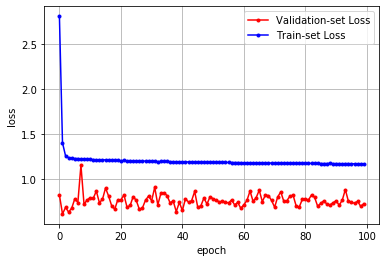

In [28]:
import matplotlib.pyplot as plt

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [29]:
y_vloss[-1]

0.725885272026062

In [30]:
yhat = []
for i in range(30):
    newX = asarray([test_X[i]])
    t = model.predict(newX).round(1)
    yhat.append(t)
    print('{0}번째 / 예측값 : {1}, 실제값 : {2}'.format(i+1, t, test_y[i]))

1번째 / 예측값 : [[6.]], 실제값 : 7.7
2번째 / 예측값 : [[6.5]], 실제값 : 6.3
3번째 / 예측값 : [[6.2]], 실제값 : 5.8
4번째 / 예측값 : [[6.7]], 실제값 : 5.4
5번째 / 예측값 : [[6.9]], 실제값 : 6.4
6번째 / 예측값 : [[6.2]], 실제값 : 5.5
7번째 / 예측값 : [[6.1]], 실제값 : 6.1
8번째 / 예측값 : [[6.3]], 실제값 : 6.0
9번째 / 예측값 : [[6.1]], 실제값 : 6.1
10번째 / 예측값 : [[6.3]], 실제값 : 5.8
11번째 / 예측값 : [[6.3]], 실제값 : 7.4
12번째 / 예측값 : [[6.2]], 실제값 : 5.7
13번째 / 예측값 : [[5.2]], 실제값 : 5.3
14번째 / 예측값 : [[6.]], 실제값 : 4.3
15번째 / 예측값 : [[6.1]], 실제값 : 4.5
16번째 / 예측값 : [[6.3]], 실제값 : 5.3
17번째 / 예측값 : [[6.2]], 실제값 : 6.3
18번째 / 예측값 : [[6.]], 실제값 : 7.0
19번째 / 예측값 : [[6.2]], 실제값 : 6.0
20번째 / 예측값 : [[5.7]], 실제값 : 5.3
21번째 / 예측값 : [[5.9]], 실제값 : 5.6
22번째 / 예측값 : [[5.9]], 실제값 : 4.5
23번째 / 예측값 : [[6.3]], 실제값 : 6.1
24번째 / 예측값 : [[5.9]], 실제값 : 4.2
25번째 / 예측값 : [[6.1]], 실제값 : 6.0
26번째 / 예측값 : [[5.5]], 실제값 : 6.1
27번째 / 예측값 : [[6.6]], 실제값 : 6.0
28번째 / 예측값 : [[6.5]], 실제값 : 6.8
29번째 / 예측값 : [[5.3]], 실제값 : 5.7
30번째 / 예측값 : [[6.7]], 실제값 : 5.7


In [31]:
yhat = np.ravel(yhat, order='C')
qwer = pd.read_csv('new_30.csv',header=None)
result_df = pd.DataFrame({'id' : qwer[0], 'predict_score' : yhat})

In [32]:
result_df

,id,predict_score
0,0,6.0
1,1,6.5
2,2,6.2
3,3,6.7
4,4,6.9
5,5,6.2
6,6,6.1
7,7,6.3
8,8,6.1
9,9,6.3
